# Summary

- orbital period modulation pretty continuous/sinusoidal
- established value is 82.37 but that fails for many flares
    - found 81.9 better but can do more to verify that it is best/how high precision can go
    - 81.9 also found in automatic periodogram function in Sec. 1
- maybe variation but amplitude ~0.04 mags in I
- another future question: changes in shape of orbital period modulation? why so easy to see sometimes (e.g. between 5000 and 6000 days)
- feature at ~6700 days from March 2013 X-ray outburst

- super-orbital: no suggestion of periodicity/repeated flaring
- super-orbital dip, but not symmetrical to any flares
- doesn't follow Corbet relation (long orbital but fast spin)

- 0.193 range in I mag; 0.147 range in V mag

- color-mag: two separate parts and added V vs. V-I
    - then one part redder when brighter, one part bluer when brighter

# Outline
- 1: Sequence of Three Auto Functions that Inform Further Search
- 2: Look for Orbital Period with Periodograms
- 3: Look for Orbital Period with LC
- 4: Look for Super-Orbital Period with Periodograms
- 5: Look for Super-Orbital Period with LC

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
orb = float(cross[cross['src_n']==4]['Porb'])
orb

82.37

In [3]:
full[full['src_n']==4]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
4,SMC718.01 \#10792 & SMC725.25 \#11632,00:59:12.74,-71:38:44.9,14.797429,-71.64596,7.5,2.763,82.37,--,--,--,--,--,14.799299999999997,-71.64715999999999,20.381,3324857,4.819137958736795


- no separation given
- **spin period 2.763 seconds and orbital 82.37 days** so inconsistent with Corbet
- March 2013 outburst

# 1: Sequence of Three Auto Functions that Inform Further Search

orbital period: 82.37


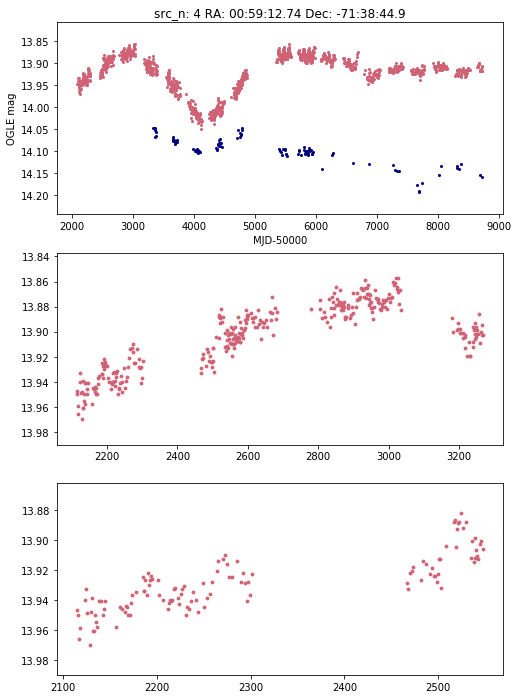

In [4]:
ilist,vlist = o.getIV(4,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

**spike around 6700 from outburst in 2014**
> orbital period quite visible 

In [5]:
idays = iband['MJD-50000']
imag = iband['I mag']
ierr = iband['I mag err']

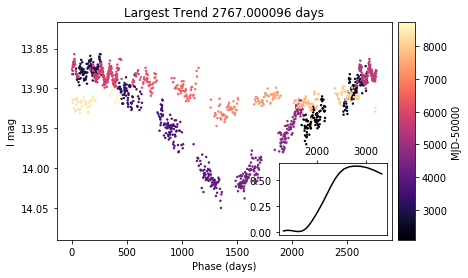

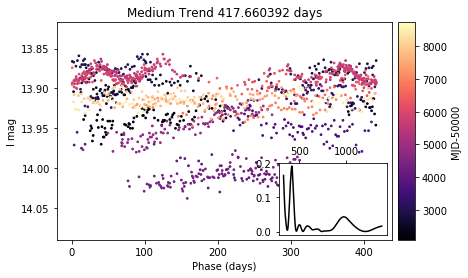

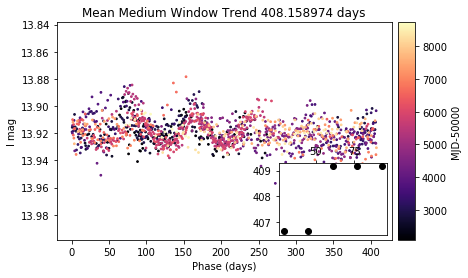

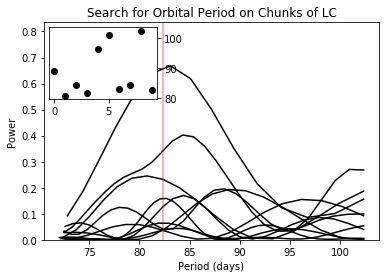

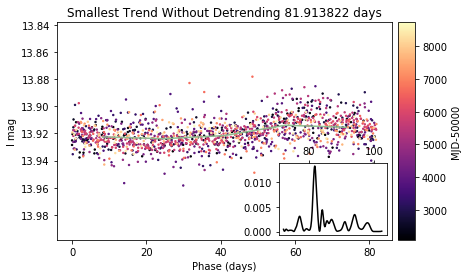

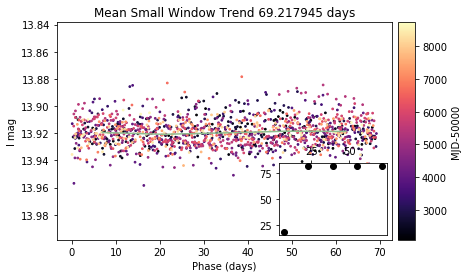

In [6]:
o.autopd(iband,orb,plotpd=True,plotphase=True,printall=False,ctime=True,orb_bounds=(10,20),cutlc=True,numcuts=10,plotdet=True,pbins=5,saveall=False,srcnum=3)

**confirmation of orbital pd already the 408 is probably the orbital period repeated/aliased**

I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744


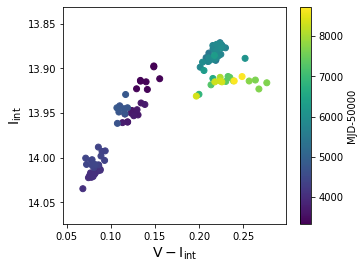

In [6]:
reload(o)
interp = o.colormag(iband,vband,ctime=True,retint=True) 

Text(0.5, 0, 'V-I')

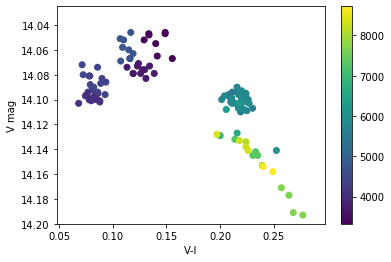

In [7]:
#V vs. V-I
plt.scatter(vband['V mag']-interp,vband['V mag'],c=vband['MJD-50000'])
plt.colorbar()
plt.ylabel('V mag')
plt.ylim(14.2,14.025)
plt.xlabel('V-I')

#### **end of LC -- turnover in color-mag**
- that's when the super-orbital trend is not really happening
- look into further

# 2: Look for Orbital Period with Periodograms

by OGLE epoch then dense regions (but can be broken up by >20 days)

In [9]:
len(ilist)

2

start ind: 0, end ind: -1
start ind: 0, end ind: -1


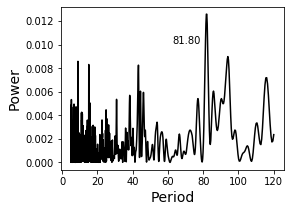

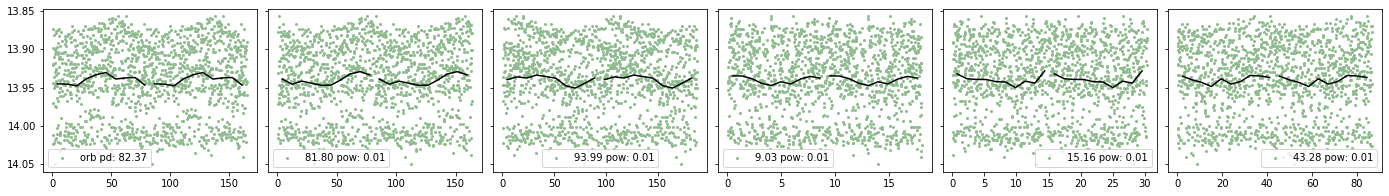

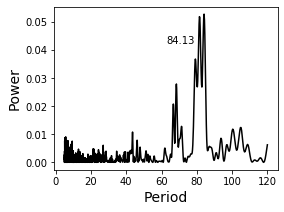

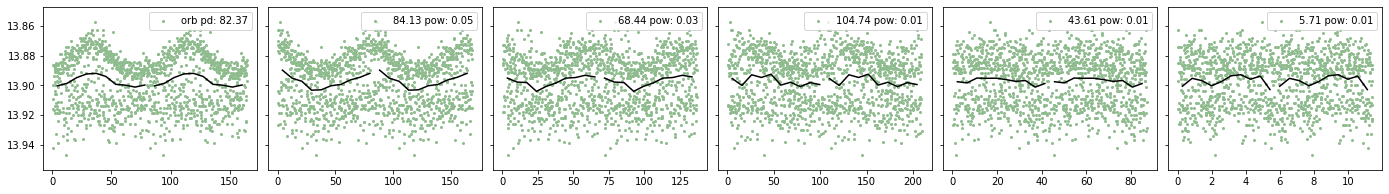

In [10]:
#without detrending
#always get high peak at exactly one day b/c of observing
df,pks = o.multiphase(ilist[0],orb=orb,dense=False,minp=5,maxp=120,plotpd=True)
df,pks = o.multiphase(ilist[1],orb=orb,dense=False,minp=5,maxp=120,plotpd=True)

both epochs close to known orbital period, and orbital period looks good in phase-folds
- next: searching closer to orbital period and detrending


<Quantity 81.66064221>

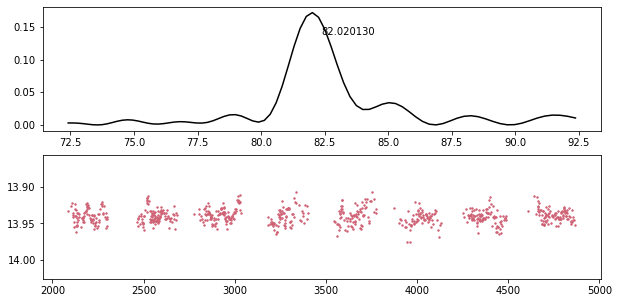

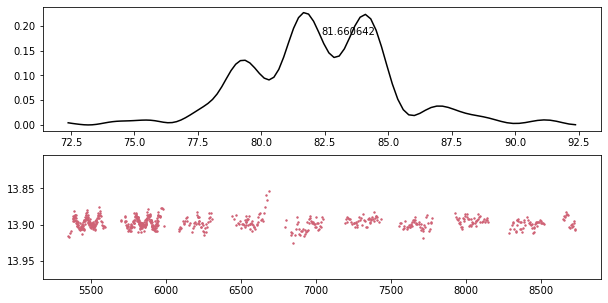

In [11]:
#detrending each OGLE epoch
#varies just a bit based on window
o.knownorb(ilist[0],orb,lower=10,upper=10,window=51,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))
o.knownorb(ilist[1],orb,lower=10,upper=10,window=51,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))

In [12]:
orb

82.37

**separate into regions**

start ind: 853, end ind: 1022


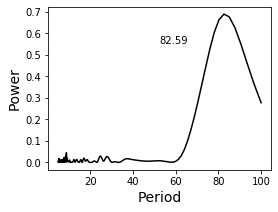

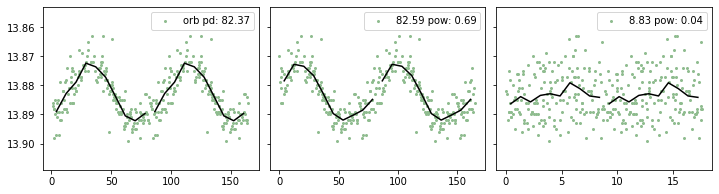

In [13]:
#search and fold with densest region (max space up to 50 points)
df,pks = o.multiphase(iband,orb=orb,dense=True,maxspace=50,minp=5,maxp=100,plotpd=True)

In [14]:
dense,mdense = o.finddense(iband,maxspace=50,retall=True)

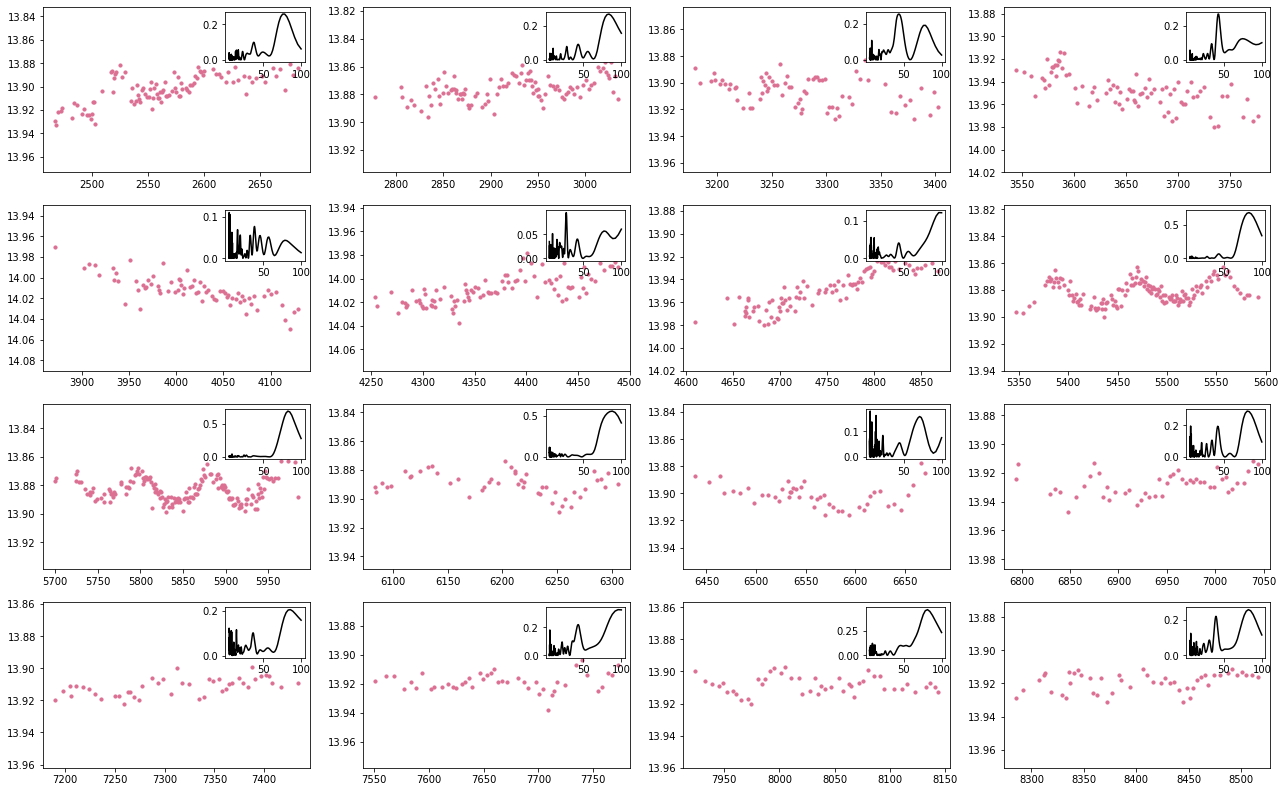

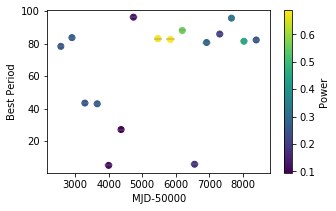

In [15]:
bps,maxpows,stdate,endate = o.denselcpd(iband,dense,maxp=100,plotbest=True,onlybp=True)

In [16]:
bps

[78.31422286270762,
 83.69246387334445,
 43.43252823126467,
 42.976780200081244,
 5.106733081927048,
 27.144331404570046,
 96.2775363201712,
 83.08635292956372,
 82.59051207281252,
 88.07827802647813,
 5.7916250686194255,
 80.68373711351734,
 85.89472343466872,
 95.68217416693163,
 81.45483620225164,
 82.2457027143763]

#### seems stable
- other best peaks just aliasing probably
- sometimes strong sinusoidal variation (esp. 5350-6000, with amplitude ~0.02 mags)

In [17]:
#make tab for each year in LC
years = []
stdate = iband['MJD-50000'][0]
endate = iband['MJD-50000'][-1]
y = 1
while y < int((endate-stdate)/365)+1:
    #less than next year
    year = iband[iband['MJD-50000']<stdate+365*y]
    #also more than previous
    year = year[year['MJD-50000']>stdate+365*(y-1)]

    years.append(year)
    y+=1

In [18]:
years[-1]['MJD-50000'][-1]

8655.92736

In [19]:
len(years)

18

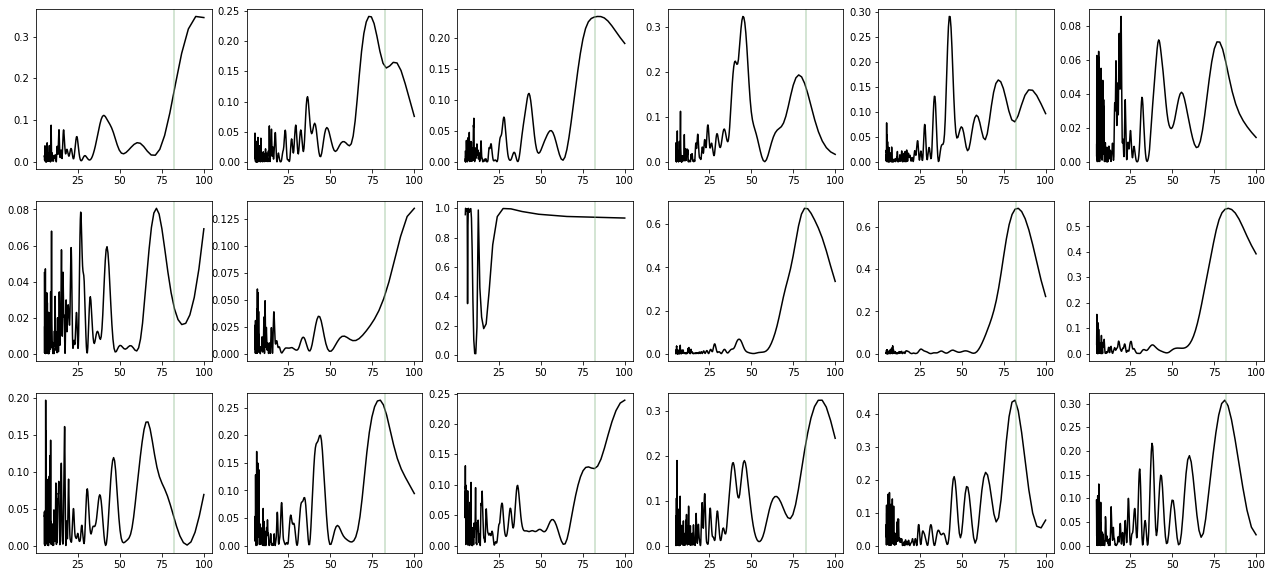

In [20]:
#with multiphase big cell but nice to see what fold of known orb looks like even when it's not a peak
reload(o)
fig = plt.figure(figsize=(22,10))
bps = []
p = 1
for y in years:
    freq,power,bp = o.periodogram(y,maxp=100,more=True,plot=False)
    bps.append(bp)
    ax = fig.add_subplot(3,6,p)
    ax.plot(1/freq,power,color='black')
    ax.axvline(orb,color='darkseagreen',alpha=0.5)
    p+=1

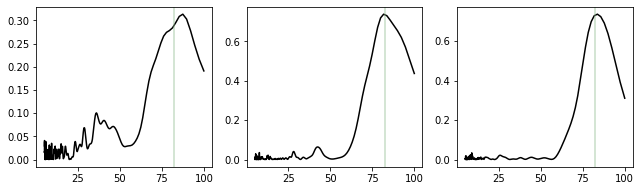

In [21]:
#repeat with detrending -- can adjust window size and then more years will have enough points
reload(o)
fig = plt.figure(figsize=(22,10))
bps = []
p = 1
for y in years:
    if len(y)>99:
        o.detrend(y,window=99)
        freq,power,bp = o.periodogram(y,maxp=100,more=True,plot=False,det=True)
        bps.append(float(bp))
        ax = fig.add_subplot(3,6,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(orb,color='darkseagreen',alpha=0.5)
        p+=1

In [22]:
bps

[87.46994195701213, 81.73571983854467, 83.72206476678825]

# 3: Look for Orbital Period with LC
- already approximately confirmed but see if in agreement with that exact value
- can skip over checkorb and go straight to orbsub; just nice to zoom in further, have more quick control

In [23]:
orb

82.37

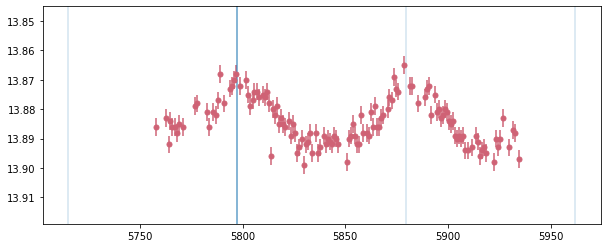

In [24]:
def checkorb(st,end,cen=5797.4,orb=orb,plcen=False,figsize=(10,4)):
    stday = idays[st:st+1]
    enday = idays[end-1:end]
    fig = plt.figure(figsize=figsize)
    plt.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    plt.ylim(maxi+.02,mini-.02)

    fline = int((stday - cen)/orb)
    lline = int((enday - cen)/orb)
    for i in range(fline-1,lline+2):
        plt.axvline(cen+orb*i,alpha=0.2)
    if plcen: plt.axvline(cen,alpha=0.6)
checkorb(870,1000,plcen=True)

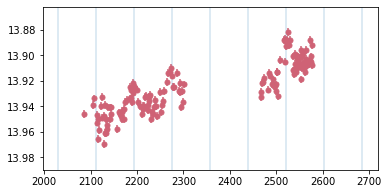

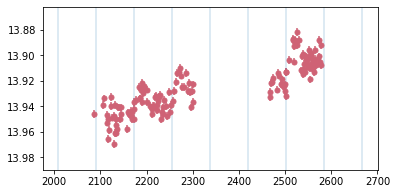

In [25]:
checkorb(0,150,figsize=(6,3),orb=81.9) #better but will have to see if it is consistently or different solution needed
checkorb(0,150,figsize=(6,3)) 


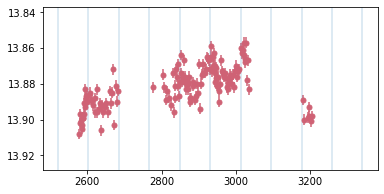

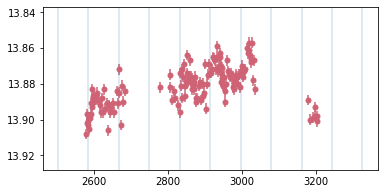

In [26]:
checkorb(150,300,figsize=(6,3),orb=81.9) #still better than original
checkorb(150,300,figsize=(6,3)) 

this part may just be difficult b/c of larger-amplitude but decently narrow fluctuations interfering? but we will see if this trend continues

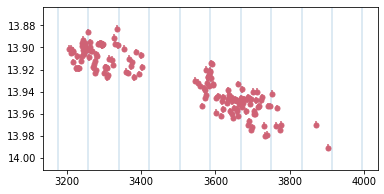

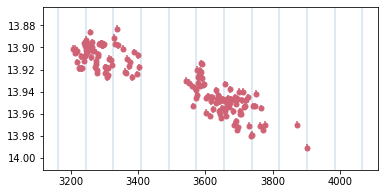

In [27]:
checkorb(300,450,figsize=(6,3),orb=81.9) #still better than original
checkorb(300,450,figsize=(6,3)) 

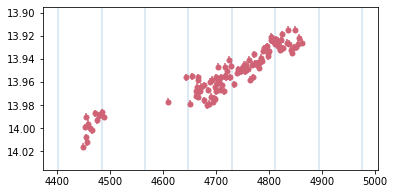

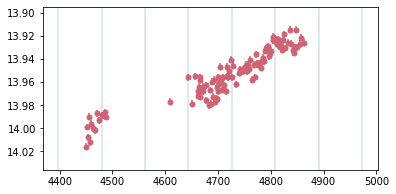

In [28]:
checkorb(600,710,figsize=(6,3),orb=81.9,cen=5795) 
checkorb(600,710,figsize=(6,3)) 

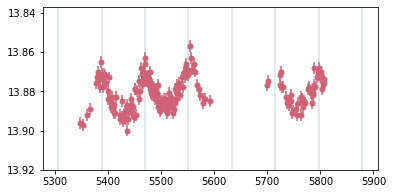

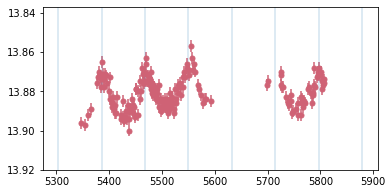

In [29]:
checkorb(711,900,figsize=(6,3),orb=81.9) #slightly better for first two but nearly identical
checkorb(711,900,figsize=(6,3)) 

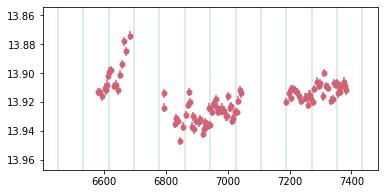

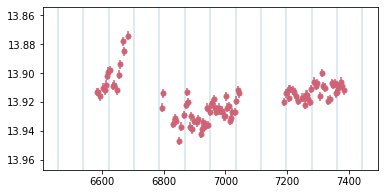

In [30]:
checkorb(1100,1200,figsize=(6,3),orb=81.9) #slightly better for first two but nearly identical
checkorb(1100,1200,figsize=(6,3)) 

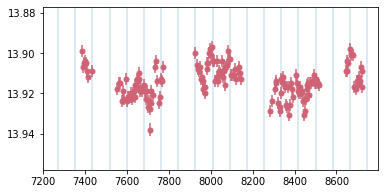

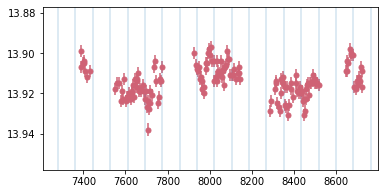

In [31]:
checkorb(1200,-1,figsize=(6,3),orb=81.9) #also supports 81.9
checkorb(1200,-1,figsize=(6,3)) 

In [32]:
def orbsub(inds,cen=5797.4,cenerr=0.4,pd=81.9,pderr=0.5,span=True,plcen=False,figsize=(22,30)):
    '''Separate full LC into subplots to better see orbital period timescale
    st,end are lists or arrays of start and end indices of each subplot
    cen: center of flare from which vertical lines are spaced (identify manually)
    add table/columns as arguments if moving to ogle.py'''
    sts = inds[:-1]
    ends = inds[1:]
    
    fig = plt.figure(figsize=figsize)
    rows = int(len(sts)/2)
    if len(sts)%2 == 1: rows+=1
    
    for i in range(len(sts)):
        st,end = sts[i],ends[i]
        #start at 1 for adding subplot
        ax = fig.add_subplot(rows,2,i+1)    
        tot = idays[end-1:end] - idays[st:st+1]
        stday = idays[st:st+1]
        enday = idays[end-1:end] 
    
        ax.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
        maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
        ax.set_ylim(maxi+.02,mini-.02)
        if plcen: ax.axvline(cen)
        fline = int((stday - cen)/pd)
        lline = int((enday - cen)/pd)
        for i in range(fline-1,lline+1):
            #propogate error of ~3 days and 1 day on period
            if span and i<4: ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
            ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)

    return

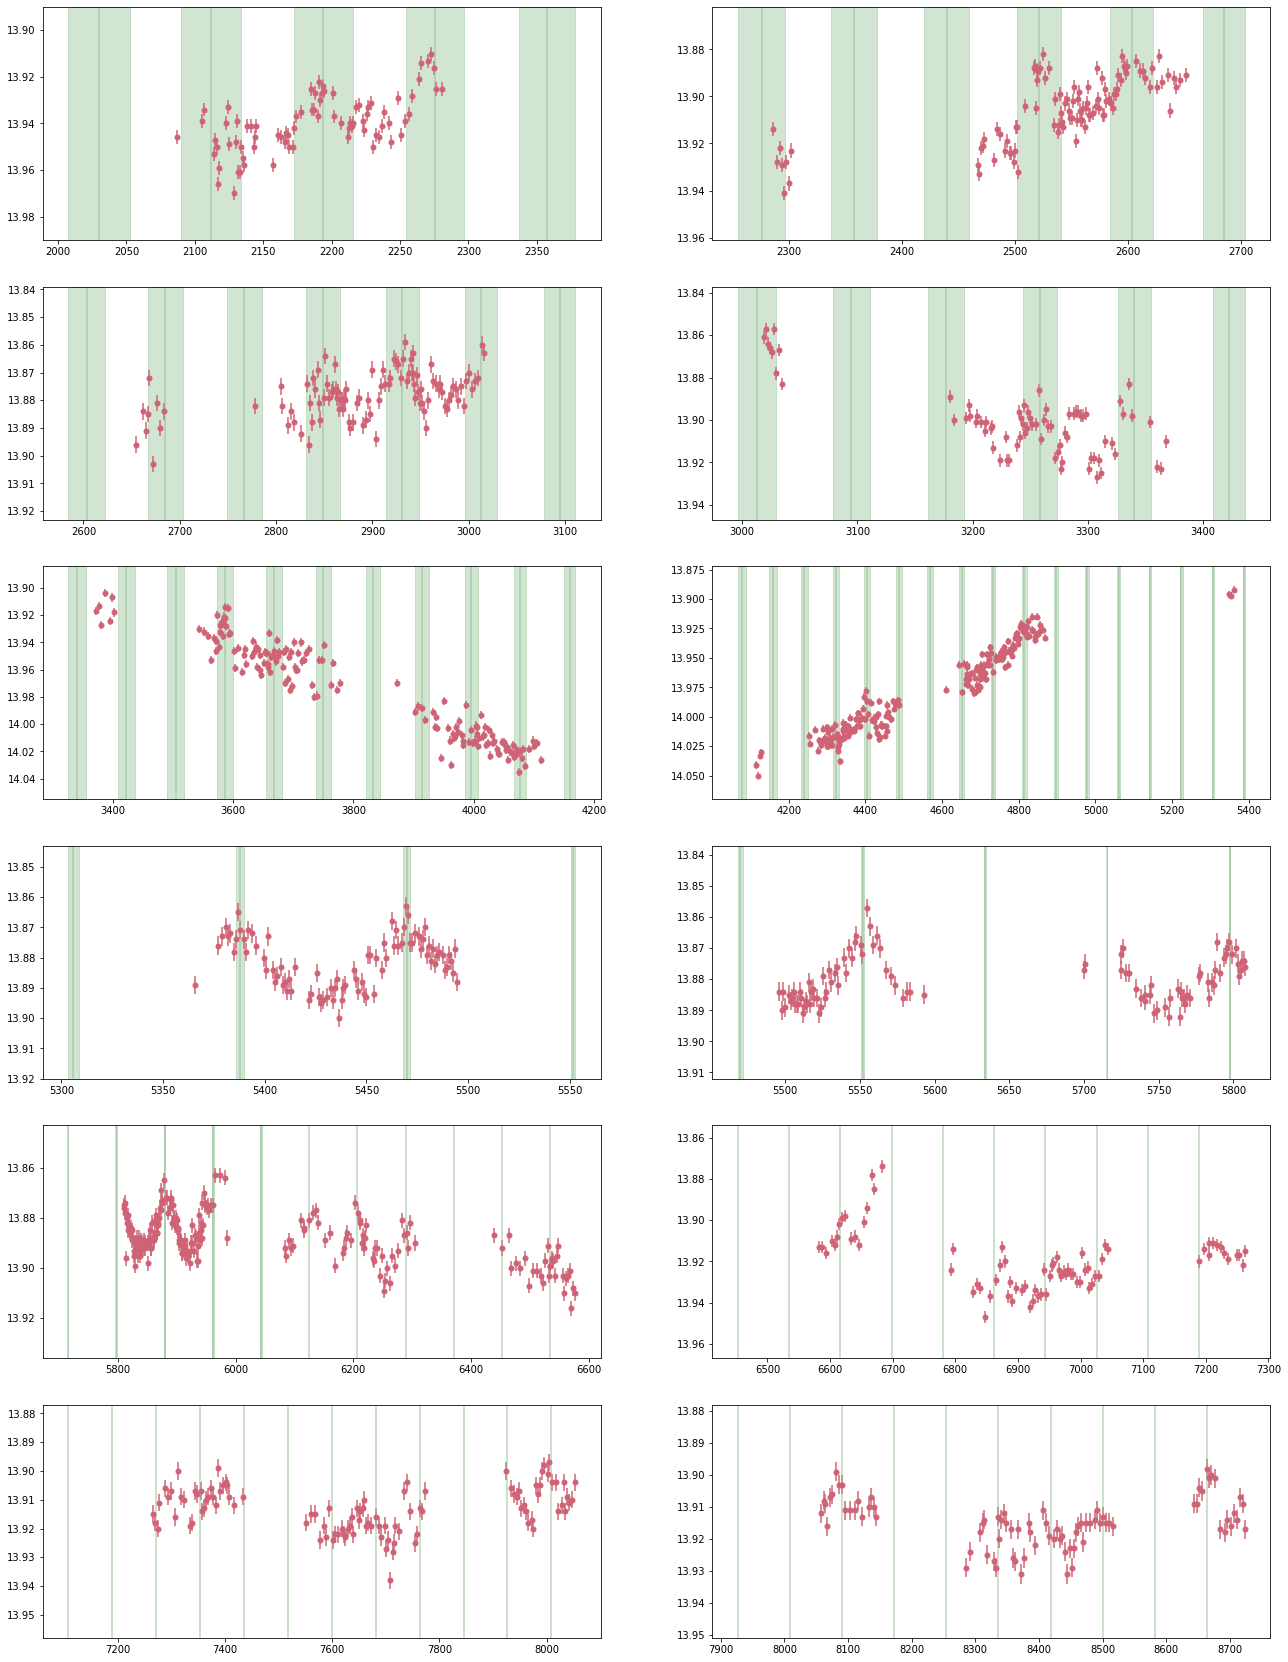

In [33]:
#list of inds to use -- easy to manipulate
#can also use finddense to not have large gaps, but then harder to control number of plots
inds = [0,79,181,284,359,517,714,800,900,1100,1177,1280,-1]
orbsub(inds)

#### shape really varies
- still some uncertainty (esp. second to last panel) but definitely better than current estimate

#### detrend and phase-fold to show this in a more concise way

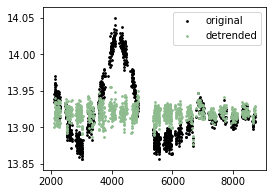

In [34]:
o.detrend(iband,window=51,plot=True)

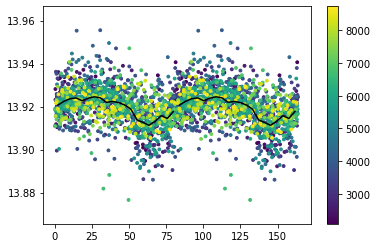

In [35]:
pd = 81.9
plt.scatter(idays%pd,iband['I detrend'],c=idays,s=8)
plt.scatter(pd+idays%pd,iband['I detrend'],c=idays,s=8)
mid,avg = o.meanphase(iband,pd,det=True)
plt.plot(mid,avg,color='black')
plt.plot(pd+mid,avg,color='black')
plt.colorbar()

(13.94, 13.9)

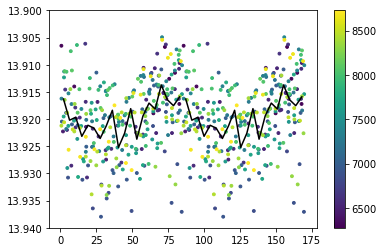

In [36]:
#place to explore final few flares
pd = 85.08 #81. better than high 82. but 85 looks best (though it doesn't look good if used above)
plt.scatter(idays[-300:]%pd,iband['I detrend'][-300:],c=idays[-300:],s=8)
plt.scatter(pd+idays[-300:]%pd,iband['I detrend'][-300:],c=idays[-300:],s=8)
mid,avg = o.meanphase(iband[-300:],pd,det=True)
plt.plot(mid,avg,color='black')
plt.plot(pd+mid,avg,color='black')
plt.colorbar()
plt.ylim(13.94,13.9)

<Quantity 85.08082306>

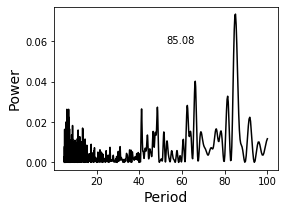

In [37]:
o.periodogram(iband[-300:],det=False,maxp=100) #same answer whether or not detrended

82.37


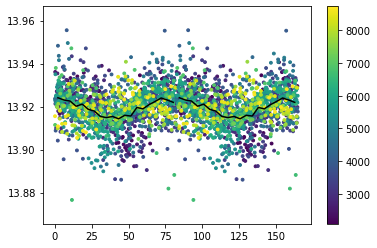

In [38]:
#repeat with orb -- pretty similar out of phase flares
plt.scatter(idays%orb,iband['I detrend'],c=idays,s=8)
plt.colorbar()
plt.scatter(orb+idays%orb,iband['I detrend'],c=idays,s=8)
mid,avg = o.meanphase(iband,orb,det=True)
plt.plot(mid,avg,color='black')
plt.plot(orb+mid,avg,color='black')
print(orb) #out of phase end and beginning?

# 4: Look for Super-Orbital Period with Periodograms

<Quantity 393.99703273>

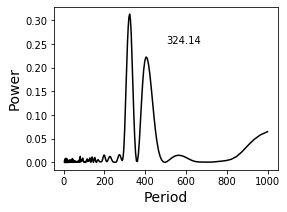

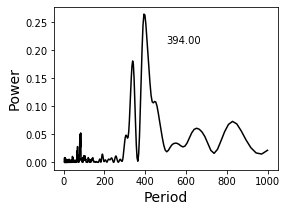

In [39]:
#each OGLE epoch
o.periodogram(ilist[0],maxp=1000)
o.periodogram(ilist[1],maxp=1000)


start ind: 0, end ind: -1


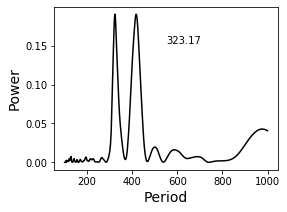

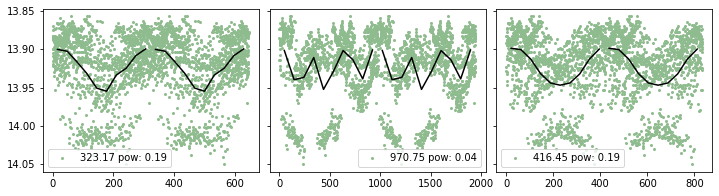

In [40]:
#full LC
df,pks = o.multiphase(iband,orb=orb,incl_orb=False,dense=False,minp=100,maxp=1000,plotpd=True)

nothing so compelling esp. considering LC below

why is it that period seen so clearly between 5000 and 6000?

# 5: Look for Super-Orbital Period with LC

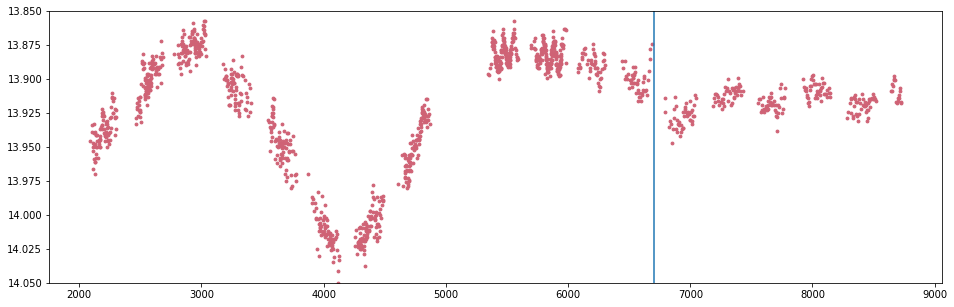

In [41]:
plt.figure(figsize=(16,5))
plt.scatter(idays,imag,color=pink,s=8)
plt.ylim(14.05,13.85)
#known outburst at the spike shown
plt.axvline(6700)